# COMP8220 Machine Learning
  ## Major Project




	Student Number: 	Umut Demirhan
	Student Name:       46739106
	Unit Convenor:      Prof Mark Dras & Dr Rolf Schwitter
	Unit Code:          COMP8220
	Unit Name:          Machine Learning
	Assignment Title:   Major Project
	Due Date:           04/11/2022
	Date of Submission: 04/11/2022

	Kaggle username:    umutdmrhn
	Kaggle profile link: https://www.kaggle.com/umutdmrhn


Direct link to the competions: https://www.kaggle.com/umutdmrhn/competitions?tab=completed

# Introduction

This notebook is for the major project submission for COMP7220/8220, on the [image/language] dataset and task.  It contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.



# Conventional ML Model

The features were HOG a nd eigenface vector. The first, we resized image then rescale it and extract Hog and eigenface vector. After that we build 2 models are SVM and Random forest. In addition we have to transform label to 3 classes.

In [3]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.decomposition import PCA
from time import time
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import cv2
import pandas as pd
from skimage.feature import hog

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
image_size = 100
dataset_directory = '/content/drive/MyDrive/facial_age'  

age_ranges = {
    (6,20) : 0, 
    (35,40) : 1, 
    (55,98) : 2
}

def convert_ranges(age):
  for key in age_ranges:
    if key[0] <= age <= key[1]:
      return age_ranges[key]


def transform_labels_age(labels_vec):
  new_labels_vec = []
  for x in labels_vec:
    x2 = x.split('-')
    new_labels_vec.append(convert_ranges(int(x2[1])))
  return np.array(new_labels_vec)

def transform_labels(labels_vec):
  return transform_labels_age(labels_vec)

In [6]:
images_train = np.load(join(dataset_directory, 'train_images.npy'))
labels_train_full = np.load(join(dataset_directory, 'train_labels.npy'))
labels_train = transform_labels(labels_train_full)

images_val = np.load(join(dataset_directory, 'val_images.npy'))
labels_val_full = np.load(join(dataset_directory, 'val_labels.npy'))
labels_val = transform_labels(labels_val_full)

images_test_public = np.load(join(dataset_directory, 'test_images.npy'))

images_train = images_train.reshape([-1, image_size, image_size, 3]) / 255.0
images_val = images_val.reshape([-1, image_size, image_size, 3]) / 255.0
images_test_public = images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0

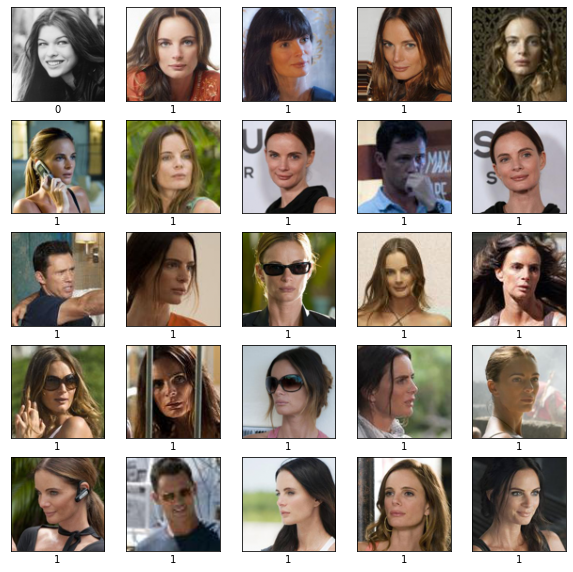

In [7]:
plt.figure(figsize=(10,10))
offset = 0
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_val[i+offset], cmap=plt.cm.binary)
    plt.xlabel(labels_val[i+offset])
plt.show()

## The code below handles feature extraction by HOG features and eigen face PCA

#### HOG

HOG, or Histogram of Oriented Gradients, is a feature descriptor often used to extract features from image data. The technique counts gradient orientation occurrences in an image's localised portion.
The HOG descriptor focuses on the structure or the shape of an object. It is better than any edge descriptor as it uses magnitude as well as the angle of the gradient to compute the features. For the regions of the image, it generates histograms using the volume and orientations of the gradient.

Source: https://towardsdatascience.com/hog-histogram-of-oriented-gradients-67ecd887675f


In [8]:
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3

In [9]:
X_train_hog=[]
y_train=[]
X_train_grey=[]

for img, label in zip(images_train, labels_train):
    img_grey=cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2GRAY)
    fd = hog(img_grey, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    featurevector=img_grey.flatten()
    X_train_hog.append(fd)
    X_train_grey.append(featurevector)
    y_train.append(label)


In [10]:
X_val_hog=[]
X_val_grey=[]
y_val=[]

for img, label in zip(images_val, labels_val):
    img_grey=cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2GRAY)
    fd = hog(img_grey, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    featurevector=img_grey.flatten()
    X_val_hog.append(fd)
    X_val_grey.append(featurevector)
    y_val.append(label)

In [11]:
X_test_hog=[]
X_test_grey=[]

for img in images_test_public:
    img_grey=cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2GRAY)
    featurevector=img_grey.flatten()
    fd = hog(img_grey, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    X_test_grey.append(featurevector)
    X_test_hog.append(fd)

#### Eigen face PCA

An eigenface is the name given to a set of eigenvectors when used in the computer vision problem of human face recognition. The eigenvectors are derived from the covariance matrix of the probability distribution over the high-dimensional vector space of face images. The eigenfaces themselves form a basis set of all images used to construct the covariance matrix. This reduces dimension by allowing the smaller set of basis images to represent the original training images. Classification can be achieved by comparing how faces are represented by the basis set. <br>
PCA is a dimensionality-reduction method often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.<br>
Combining these methods we will have final feature vectors to apply the machine learning model on it.

Source: https://en.wikipedia.org/wiki/Eigenface

In [12]:
n_components=64

pca = PCA(n_components=n_components, whiten=True).fit(X_train_grey)

eigenfaces = pca.components_.reshape((n_components, 100, 100))
X_train_pca = pca.transform(X_train_grey)
X_val_pca = pca.transform(X_val_grey)
X_test_pca = pca.transform(X_test_grey)

Plot eigenface features

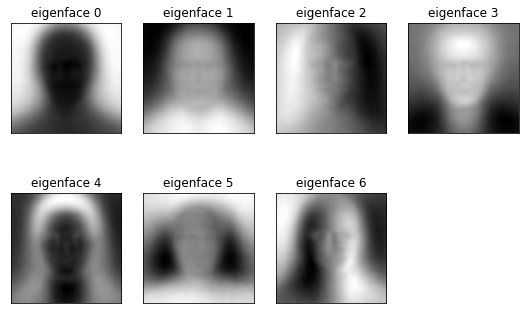

In [13]:
import matplotlib.pyplot as plt
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(7):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 100, 100)

## SVM

A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for classification problems. After giving an SVM model set of labelled training data for each category, they’re able to categorize new input.
Compared to newer algorithms like neural networks, they have two main advantages: higher speed and better performance with a limited number of samples (in the thousands). This makes the algorithm very suitable for small datasets.

Sources:

https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [14]:
svm_eigen  = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale')
svm_eigen.fit(X_train_pca, y_train)
y_pred_eigen = svm_eigen.predict(X_val_pca)

In [15]:
svm_hog = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale')
svm_hog.fit(X_train_hog, y_train)
y_pred_hog = svm_hog.predict(X_val_hog)

In [16]:
print("Accuracy of EigenFace and SVM:", svm_eigen.score(X_val_pca, y_val))
print("Accuracy of Hog and SVM:", svm_hog.score(X_val_hog, y_val))

Accuracy of EigenFace and SVM: 0.5853564547206166
Accuracy of Hog and SVM: 0.6269749518304432


In [17]:
target_names=["0", "1", "2"]

In [18]:
print(classification_report(y_val, y_pred_eigen, target_names=target_names))

              precision    recall  f1-score   support

           0       0.42      0.12      0.19       529
           1       0.61      0.85      0.71      1479
           2       0.51      0.33      0.40       587

    accuracy                           0.59      2595
   macro avg       0.51      0.43      0.43      2595
weighted avg       0.55      0.59      0.53      2595



In [19]:
print(classification_report(y_val, y_pred_hog, target_names=target_names))

              precision    recall  f1-score   support

           0       0.56      0.33      0.42       529
           1       0.65      0.82      0.72      1479
           2       0.57      0.41      0.48       587

    accuracy                           0.63      2595
   macro avg       0.59      0.52      0.54      2595
weighted avg       0.61      0.63      0.61      2595



The SVM model on HOG features is better than SVM eigenfave vectors. (63% accuracy). Maybe because eigenface reduce size of images so that it reduce important features.

## Random forest

Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification problems. It builds decision trees on different samples and takes their majority vote for classification.

One of the most important features of the Random Forest model is that it can handle the data set containing continuous variables as in the case of categorical variables as in the case of classification. It performs better results for classification problems.

It solves the problem of overfitting as output is based on majority voting or averaging and performs well even if the data contains null/missing values.

Sources:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/

In [20]:
from sklearn.ensemble import RandomForestClassifier

fr_eigen = RandomForestClassifier()
fr_eigen.fit(X_train_pca, y_train)
y_pred_eigen = fr_eigen.predict(X_val_pca)

In [21]:
fr_hog = RandomForestClassifier()
fr_hog.fit(X_train_hog, y_train)
y_pred_hog = fr_hog.predict(X_val_hog)

In [22]:
print("Accuracy of EigenFace and Random forest:", fr_eigen.score(X_val_pca, y_val))
print("Accuracy of Hog and Random forest:", fr_hog.score(X_val_hog, y_val))

Accuracy of EigenFace and Random forest: 0.5745664739884393
Accuracy of Hog and Random forest: 0.5845857418111753


In [23]:
print(classification_report(y_val, y_pred_eigen, target_names=target_names))

              precision    recall  f1-score   support

           0       0.42      0.08      0.14       529
           1       0.59      0.88      0.71      1479
           2       0.49      0.24      0.32       587

    accuracy                           0.57      2595
   macro avg       0.50      0.40      0.39      2595
weighted avg       0.54      0.57      0.51      2595



In [24]:
print(classification_report(y_val, y_pred_hog, target_names=target_names))

              precision    recall  f1-score   support

           0       0.59      0.10      0.18       529
           1       0.59      0.92      0.72      1479
           2       0.50      0.18      0.27       587

    accuracy                           0.58      2595
   macro avg       0.56      0.40      0.39      2595
weighted avg       0.57      0.58      0.51      2595



In [25]:
df_svm = {
    "ID":[],
    "Prediction": []
}

In [26]:
predicted = svm_hog.predict(X_test_hog)

The Random forest model on HOG features is better than Random forest eigenface vectors. (59% accuracy). Because eigenface and PCA is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets so maybe it lost more important features when applying PCA. Additionally, the principal components are often difficult to interpret (not intuitive), and usually do not improve the classification performance.

In [27]:
df_svm["ID"] = [i for i in range(len(X_test_hog))]
df_svm["Prediction"] = predicted

In [28]:
pd.DataFrame(df_svm).to_csv("/content/result.csv", index=False)

# Notes on the Conventional ML Model

For the final model SVM, hyperparameters were chosen by C=1.0, kernel='rbf', degree=3, gamma='scale'. In addition to the final model, I also tried a random forest model. This performed fairly poorly (accuracy 57%) smaller than 63% This may have been because HOG is suitable with SVM.

I first tried HOG features with an SVM and Random forest, and this performed is good, the accuracy of 63%; selecting features with eigenface; the final SVM model performed better still, with a similar pattern of performance with respect to the features. SVM is better than Random forest maybe because it's effective in high dimensional spaces and still effective in cases where the number of dimensions is greater than the number of samples, suitable with images.

Random Forest is intrinsically suited for multiclass problems, while SVM is intrinsically two-class. For multiclass problems, SVM will need to reduce them into multiple binary classification problems.

Random Forest works well with a mixture of numerical and categorical features. When features are on various scales, it is also fine. Roughly speaking, with Random Forest you can use data as they are. SVM maximizes the "margin" and thus relies on the concept of "distance" between different points. It is up to you to decide if "distance" is meaningful. As a consequence, one-hot encoding for categorical features is a must-do. Further, min-max or other scaling is highly recommended at preprocessing step. And because we applied some preprocessing steps so that SVM can archive better performance than random forest.

Source: https://datascience.stackexchange.com/questions/6838/when-to-use-random-forest-over-svm-and-vice-versa

# Deep Learning Model

The input was the raw data that had been preprocessed by resize and rescale.

Source: https://keras.io/api/

In [29]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model

In [30]:
y_train = tf.keras.utils.to_categorical(labels_train)
y_val = tf.keras.utils.to_categorical(labels_val)

In [31]:
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential

In [32]:
model= Sequential()
model.add(Conv2D(filters=64,strides=1, kernel_size=(3,3), activation='relu', input_shape=(100, 100,3)))
model.add(MaxPooling2D(3,3))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(3,3))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation = 'softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])

In [33]:
myCallbacks = [
    keras.callbacks.EarlyStopping(monitor='val_acc',patience=20),
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/facial_age/logs/model_{val_acc:.2f}.h5',
                                    monitor='val_acc',mode='max',save_best_only=True)    
]

In [34]:
history = model.fit(
      images_train, y_train,
      epochs = 100,
      shuffle=False,
      verbose = 1,
      validation_data = (images_val, y_val),
      # callbacks= myCallbacks,
      batch_size=32
      )

Epoch 1/100
422/422 [==============================] - 18s 17ms/step - loss: 1.0714 - acc: 0.4622 - val_loss: 0.9926 - val_acc: 0.5699
Epoch 2/100
422/422 [==============================] - 6s 15ms/step - loss: 1.0637 - acc: 0.4736 - val_loss: 0.9931 - val_acc: 0.5699
Epoch 3/100
422/422 [==============================] - 6s 15ms/step - loss: 1.0610 - acc: 0.4691 - val_loss: 0.9862 - val_acc: 0.5699
Epoch 4/100
422/422 [==============================] - 6s 14ms/step - loss: 1.0519 - acc: 0.4747 - val_loss: 0.9723 - val_acc: 0.5699
Epoch 5/100
422/422 [==============================] - 6s 14ms/step - loss: 1.0366 - acc: 0.4859 - val_loss: 0.9586 - val_acc: 0.5688
Epoch 6/100
422/422 [==============================] - 6s 14ms/step - loss: 1.0209 - acc: 0.5024 - val_loss: 0.9478 - val_acc: 0.5726
Epoch 7/100
422/422 [==============================] - 6s 14ms/step - loss: 1.0058 - acc: 0.5117 - val_loss: 0.9331 - val_acc: 0.5742
Epoch 8/100
422/422 [==============================] - 6s 14m

In [35]:
result = model.predict(images_test_public)

75/75 [==============================] - 1s 7ms/step


In [36]:
result = np.argmax(result,axis=1)
result

array([1, 2, 2, ..., 0, 1, 1])

In [37]:
df_deep = {
    "ID":[],
    "Prediction": []
}

In [38]:
df_deep["ID"] = [i for i in range(len(images_test_public))]
df_deep["Prediction"] = result

In [39]:
pd.DataFrame(df_deep).to_csv("/content/46739106-deep.csv", index=False)

# Notes on the Deep Learning Model

For the final model, hyperparameters were chosen by 3 conv layers

In addition to the final model, I also tried a CNN with two conv layers and don't use maxpooling layers. This performed almost as well as the final model (accuracy 55%). This gap in performance may have been because 2conv layers is not enough. 
 When the training model gets the highest accuracy on validation data(64%) at epoch 20 (after this epoch accuracy is not improved or even decreases), the model may overfit over epoch 20, so we could stop the model at this epoch as we got the best accuracy on validation.

# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models, the deep learning one performed better by 2% on the public test set. 
Deep learning is better because of neural layers, we built 3 convolutional layers to extract features from images, then feed them to fully connected layers to classify with softmax function. We use Adam as the optimization function because this function is better than another in avoiding exploding gradient.

Neural net does through backprop and gradient descent could very well be considered to be learning a kernel, only instead of having a nice functional form, it's composed (literally) of a large number of applications of a basic nonlinearity, with some additions and multiplications thrown in. The next-to-last layer of a typical classification network is the result of this. Also, Neural networks do a decent job at learning the important features from basically any data structure, without having to manually derive features.

We also can improve accuracy by filtering the dataset, because we have considerable noise in this data so the model can't work full performance.

Sources: 
https://stats.stackexchange.com/questions/510052/are-neural-networks-better-than-svms

https://towardsdatascience.com/an-introduction-to-gradient-descent-and-backpropagation-81648bdb19b2